In [35]:
# This notebook checks MNE functions for ECG and EOG detection
# Cropped data is used here (5 minutes only), tried on whole data - takes forever.


#Load data, make folders
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import mne
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
import configparser
from main_meg_qc import make_derivative_meg_qc, sanity_check, initial_stuff



In [36]:
config = configparser.ConfigParser()
config.read('settings.ini')
data_file='/Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds003483/sub-009/ses-1/meg/sub-009_ses-1_task-deduction_run-1_meg.fif'
sid='009'

dict_of_dfs_epoch, epochs_mg, channels, raw_filtered, raw_filered_resampled, raw_cropped, raw = initial_stuff(config, data_file)
m_or_g_chosen = ['mags', 'grads']

m_or_g_chosen = sanity_check(m_or_g_chosen, channels)

if len(m_or_g_chosen) == 0: 
    raise ValueError('No channels to analyze. Check presence of mags and grads in your data set and parameter do_for in settings.')


default_section = config['DEFAULT']
tmin = default_section['data_crop_tmin']
tmax = default_section['data_crop_tmax']

if not tmin: 
    tmin = 0
else:
    tmin=float(tmin)
if not tmax: 
    tmax = raw.times[-1] 
else:
    tmax=float(tmax)

duration = tmax-tmin

print('Data duration is ', duration, ' seconds')

Opening raw data file /Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds003483/sub-009/ses-1/meg/sub-009_ses-1_task-deduction_run-1_meg.fif...
    Range : 60000 ... 1255999 =     60.000 ...  1255.999 secs
Ready.
Stimulus channels detected: ['STI101', 'STI201', 'STI301']
9 events found
Event IDs: [2 4 8]
Trigger channel has a non-zero initial value of 3840 (consider using initial_event=True to detect this event)
Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
Loading data for 9 events and 1201 original time points ...
0 bad epochs dropped
Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
Loading data for 9 events and 1201 original time points ...
0 bad epochs dropped
Data duration is  95.99900000000002  seconds


In [37]:
# Find channel names:

picks_ECG = mne.pick_types(raw_cropped.info, ecg=True)
picks_EOG = mne.pick_types(raw_cropped.info, eog=True)
if picks_ECG.size == 0:
    print('No ECG channels found is this data set')
if picks_EOG.size == 0:
    print('No EOG channels found is this data set')
else:
    ECG_channel_name=[]
    for i in range(0,len(picks_ECG)):
        ECG_channel_name.append(raw.info['chs'][picks_ECG[i]]['ch_name'])
    
    EOG_channel_name=[]
    for i in range(0,len(picks_EOG)):
        EOG_channel_name.append(raw.info['chs'][picks_EOG[i]]['ch_name'])
    print('ECG channel: ', ECG_channel_name)
    print('EOG channels: ',EOG_channel_name)

#Look at the stimulus channel (can limit to only 3-6 sec here for example, or not):
#raw_bandpass.copy().pick_types(meg=False, stim=True).plot(start=3, duration=6)
raw_cropped.copy().pick_types(meg=False, stim=False,ecg=True).plot()
raw_cropped.copy().pick_types(meg=False, stim=False,eog=True).plot()


ECG channel:  ['ECG062']
EOG channels:  ['EOG061']
Opening raw-browser...
Using pyopengl with version 3.1.1a1
Opening raw-browser...
Using pyopengl with version 3.1.1a1


Closing raw-browser...
Channels marked as bad:
none


In [38]:
raw_cropped

<Raw | sub-009_ses-1_task-deduction_run-1_meg.fif, 320 x 96000 (96.0 s), ~5.3 MB, data not loaded>

In [32]:
#HERE WE DROP THE ECG CHANNEL TO TRY TO RECONSTRUCT ECG EVENTS ON BASE OF MAGNETOMETERS.
# RESULTS IS WORSE. IT FINDS NOW 95 INSTEAD OF 62 EVENTS! SPEAKS ALSO TO HOW REASONABLE 
# IT IS TO DO RECONSTRUCTION AT ALL. MAYBE WE SHOULD NOT EVEN GIVE SUCH OPTION? 
# OR COME UP WITH IDEA HOW TO EVALUATE THE RESULT OF RECONSTRUCTION.

raw_cropped.drop_channels(ECG_channel_name)

<Raw | sub-009_ses-1_task-deduction_run-1_meg.fif, 319 x 96000 (96.0 s), ~5.3 MB, data not loaded>

In [45]:

#Find ECG events by localizing the R wave peaks.

ecg_events, ch_ecg, average_pulse, ecg=mne.preprocessing.find_ecg_events(raw_cropped, return_ecg=True, verbose=True)
# can explicitely give ECG channel here but not nessesary. MNE can detect it automatically.

# ecg_events array
# The events corresponding to the peaks of the R waves.
# ch_ecg - str - Name of channel used.

# average_pulse float
# The estimated average pulse. If no ECG events could be found, this will be zero.

# ecg array | None
# The ECG data of the synthesized ECG channel, if any. This will only be returned if return_ecg=True was passed.

# HOW TO FIND THE TIME OF EVENTS:
# https://github.com/mne-tools/mne-python/issues/5201
ecg_events_times  = (ecg_events[:, 0] - raw.first_samp) / raw.info['sfreq']

#https://mne.tools/stable/glossary.html#term-first_samp
#The first_samp attribute of Raw objects is an integer representing the number of time samples that passed between 
# the onset of the hardware acquisition system and the time when data recording started. This approach to sample 
# numbering is a peculiarity of VectorView MEG systems, but for consistency it is present in all Raw objects regardless 
# of the source of the data. In other words, first_samp will be 0 in Raw objects loaded from non-VectorView data files.

# checg=ch_ecg.tolist()
# ECG_channel_name_auto=[]
# for i in range(0,len([checg])):
#     ECG_channel_name_auto.append(raw.info['chs'][checg][i]['ch_name'])

# #print('ECG events: \n', ecg_events) 
# print('Channels used to detect ECG: ', ECG_channel_name_auto) 

print('Average pulse: ', average_pulse) 
print('ECG data of the synthesized ECG channel: \n',ecg)
print('Times of ECG events: \n', ecg_events_times)
print('ECG channel used: ', raw_cropped.info['chs'][ch_ecg]['ch_name'])

Using channel ECG062 to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Number of ECG events detected : 115 (average pulse 71 / min.)
Average pulse:  71.875
ECG data of the synthesized ECG channel: 
 [[1.96511644e-19 1.36168480e-06 2.67899992e-06 ... 2.14406204e-06
  1.08227289e-06 2.43098456e-19]]
Times of ECG events: 
 [1100.603 1101.505 1102.372 1103.236 1104.098 1104.959 1105.789 1106.612
 1107.428 1108.25  1109.048 1109.851 1110.661 1111.473 1112.257 1113.053
 1113.857 1114.679 1115.482 1116.29  1117.084 1117.858 1118.593 1119.

In [34]:
len(ecg_events)

# THE RECONSTRUCTION OF ECG EVENTS MY MNE ON BASE OF MAGNETOMETERS MAY GIVE WRONG RESULT: 
# CREATED HERE 95 EVENTS, WITH ECG CHANNEL ON SAME DATA 62 EVENTS


144

Closing raw-browser...
Channels marked as bad:
none
Closing raw-browser...
Channels marked as bad:
none


In [41]:
#Plot the found ECG events on one of the channels:

data_mags=raw_cropped.get_data(picks = channels['mags'])
data_grads=raw_cropped.get_data(picks = channels['grads'])

dt=duration/len(data_mags[5]) #take 1 random mag channel, for example 5

t=np.arange(tmin, tmax, 1/raw.info['sfreq'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=data_mags[2], name='data'));
#fig.add_vline(x=ecg_events_times, line_width=1, line_dash="dash", line_color="green")
for ecg in ecg_events_times:
    fig.add_vline(x=ecg, line_width=1, line_color="green")

fig.update_layout(
    title={
    'text': "ECG events on data of 1 magnetometer",
    'y':0.85,
    'x':0.5,
    'xanchor': 'center',
    'yanchor': 'top'},
    xaxis_title="Time in sec",
    yaxis = dict(
        showexponent = 'all',
        exponentformat = 'e'))

fig.show()

Using channel ECG062 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Number of ECG events detected : 115 (average pulse 71 / min.)
Not setting metadata
115 matching events found
No baseline correction applied
Loading data for 115 events and 1001 original time points ...
0 bad epochs dropped
Not setting metadata
115 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


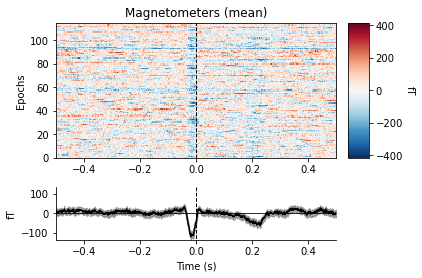

Figure(432x288)


/Users/jenya/opt/anaconda3/envs/mne_new/lib/python3.9/site-packages/mpld3/mplexporter/exporter.py:84: UserWarning:

Blended transforms not yet supported. Zoom behavior may not work as expected.



In [53]:
#THIS FUNCTION CREATES EPOCHS ON BASE OF ECG EVENTS. 
# It calls find_ecg_events internally, so no need to run previous cell for it.

%matplotlib inline

m_or_g = 'mags'
ecg_epochs = mne.preprocessing.create_ecg_epochs(raw_cropped)
f=ecg_epochs.plot_image(combine='mean', picks=m_or_g[0:-1])[0]
print(f)

import mpld3
mpld3.save_html(f,'myfig.html')

Applying baseline correction (mode: mean)
No projector specified for this dataset. Please consider the method self.add_proj.


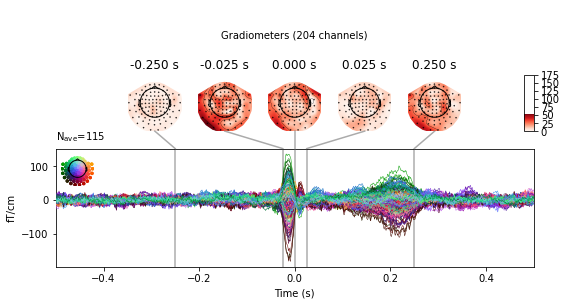

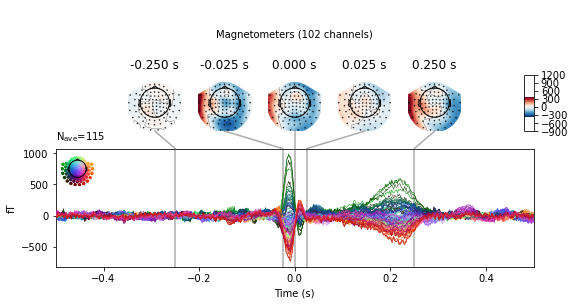

[<Figure size 576x302.4 with 9 Axes>, <Figure size 576x302.4 with 9 Axes>]

In [54]:
# Here I simply repeat the steps from mne tutorial:
# https://mne.tools/stable/auto_tutorials/preprocessing/10_preprocessing_overview.html#sphx-glr-auto-tutorials-preprocessing-10-preprocessing-overview-py

#averaging the ECG epochs together:
avg_ecg_epochs = ecg_epochs.average().apply_baseline((-0.5, -0.2))

avg_ecg_epochs.plot_joint(times=[-0.25, -0.025, 0, 0.025, 0.25])
# I guess 0 represents the actual ECG event and all around - the epoch and how the ECG signal developes during 
# the ECG epoch on everage over all channels?


In [ ]:
# How to do correlations of the shape of mean ecg with the data. To see which channels are contaminated most.
# Jochem describedd in the meeting:
# - average epochs around ECG events channel wise -> vector 
# - divide vector by norm (square root of dot product of vector with itself) --> vector of length 1 (reference heartbeat vector)
# - dot product between epoch and norm vector
# (look up in the Statistical Learning course again)


# - 1. average epochs around ECG events channel wise -> vector 
ecg_evoked = mne.preprocessing.create_ecg_epochs(raw_cropped).average()
print(ecg_evoked.data[0, :]) # for example: averaged ECG event (evoked) data of first channel, all timepoints

# Project vector of average ECG artifact onto epoch vector:
# - divide vector by norm (square root of dot product of vector with itself) --> vector of length 1 (reference heartbeat vector)
# - dot product between epoch and norm vector
#  
v=ecg_evoked.data[0, :]

df_m = epochs_mags[3, 0].to_data_frame()
ep= epochs_mags

# General VECTOR PROJECTION technique: https://www.geeksforgeeks.org/vector-projection-using-python/
v_to_ep_proj = (np.dot(ep, v)/np.dot(v, v))*v

# But according to Jochems paper, need to project epoch (data+ noise) onto the noise (ecg_evoked), not the other way around? 
# To find the noise component in the epoch.


# _____________

# Actually, found mne.preprocessing.compute_proj_ecg which seemst to be already doing all the described steps. Is this what we need?
#
# "Compute SSP (signal-space projection) vectors for ECG artifacts.

# This function will:

# Filter the ECG data channel.

# Find ECG R wave peaks using mne.preprocessing.find_ecg_events().

# Filter the raw data.

# Create Epochs around the R wave peaks, capturing the heartbeats.

# Optionally average the Epochs to produce an Evoked if average=True was passed (default).

# Calculate SSP projection vectors on that data to capture the artifacts.

# Evoked objects typically store EEG or MEG signals that have been averaged over multiple epochs,

# 

# _______
# Evoked: shape (n_channels, n_times)
# Epoch: shape (n_epochs, n_channels, n_times)


In [ ]:
df_m = epochs_mags[3].to_data_frame()

df_m

In [56]:
# Find EOG events:
# https://mne.tools/stable/generated/mne.preprocessing.find_eog_events.html

eog_events=mne.preprocessing.find_eog_events(raw, thresh=None, ch_name=None)
# threshfloat | None
# Threshold to trigger the detection of an EOG event. This controls the thresholding of the underlying 
# peak-finding algorithm. Larger values mean that fewer peaks (i.e., fewer EOG events) will be detected. 
# If None, use the default of (max(eog) - min(eog)) / 4, with eog being the filtered EOG signal.

# UNLIKE ECG, CAN NOT RECONSTRUCT EOG EVENTS IF NO DEDICATED CHANNEL IS PRESENT. SO EPOCHS CANT BE CREATED EITHER
# AS EOG channels it needs either: with type eog or ordinary EEG channel that was placed close to the eyes, like Fp1 or Fp2

# But we dont have any of these

# Another related function, but again needs EOG channel or other channels where EOG should be extracted from:
# https://mne.tools/stable/generated/mne.preprocessing.ICA.html#mne.preprocessing.ICA.find_bads_eog

eog_events_times  = (eog_events[:, 0] - raw.first_samp) / raw.info['sfreq']


Using EOG channel: EOG061
EOG channel index for this subject is: [306]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 384 significant peaks
Number of EOG events detected: 384


In [ ]:
# RUN THIS CELL ONLY IF YOU DONT HAVE EOG CHANNELS

# "If you don’t have an EOG channel, find_bads_eog has a ch_name parameter that you can use as a proxy for EOG. 
# You can use a single channel, or create a bipolar reference from frontal EEG sensors and use that as virtual EOG channel. 
# This carries a risk however: you must hope that the frontal EEG channels only reflect EOG and not brain dynamics in 
# the prefrontal cortex (or you must not care about those prefrontal signals)."

# So here I plot the magnetometers layout, choose 4 magnetometers near the eyes and try to extract eyeblinks from there

# What is better mags or grads for eyeblinks reconstruction? Or both?

%matplotlib inline

layout_from_raw=mne.channels.find_layout(raw.info, ch_type='mag')
fig=layout_from_raw.plot()

eog_events=mne.preprocessing.find_eog_events(raw, thresh=1e-8, ch_name=['MEG0521', 'MEG0911', 'MEG0511', 'MEG0921'])
# Threshold to trigger the detection of an EOG event. This controls the thresholding of the underlying peak-finding algorithm. 
# Larger values mean that fewer peaks (i.e., fewer EOG events) will be detected. 
# If None, use the default of (max(eog) - min(eog)) / 4, with eog being the filtered EOG signal.

# Detected only 3 EOG events in th entire 1h dataset if threshold is set to defailt: thresh=None
# -> Try to adjust threshold or, maybe it just doesnt really work.
# -> Above: set the threshold to 1e-8, detects 17 eyeblink events - also too little. But I got no idea what threshold value is optimal.

#%% Now want to see the data for these 4 channels I chose for eyeblinks:
chans = ['MEG0521', 'MEG0911', 'MEG0511', 'MEG0921']

#I only know how to plot channels by the idexes, not by names, so have to extract indexes first:
EOG_ch=[]
for c in chans:
    ch=[item for item in mags if c in item]
    EOG_ch.append(ch[0][1])

%matplotlib qt
raw.plot(order=EOG_ch, start=12, duration=4) #plot here only a part of channel."

#Lets discuss if these look like eyeblink!

Using EOG channel: EOG061
EOG channel index for this subject is: [306]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 384 significant peaks
Number of EOG events detected: 384
Not setting metadata
384 matching events found
Applying baseline correction (mode: mean)
Loading data for 384 events and 1001 original time points ...
0 bad epochs dropped
Not setting metadata
384 matching events found
No baseline correction

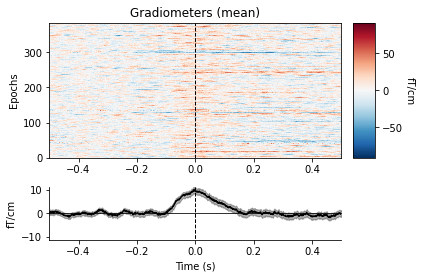

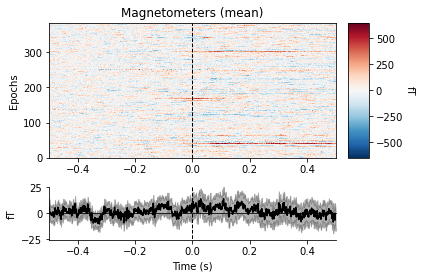

No projector specified for this dataset. Please consider the method self.add_proj.


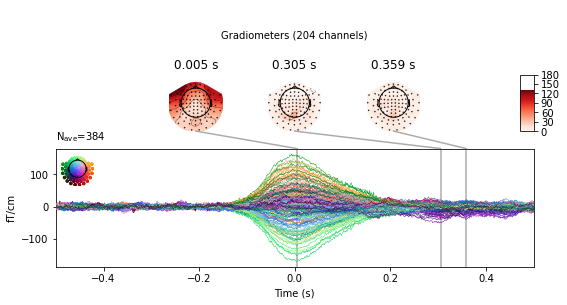

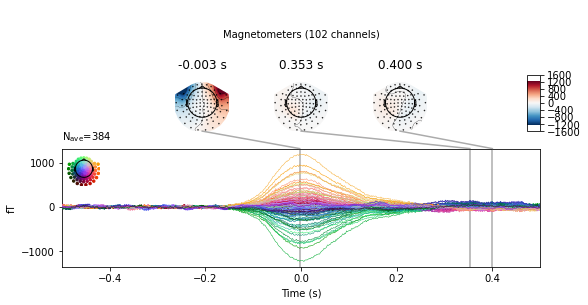

[<Figure size 576x302.4 with 7 Axes>, <Figure size 576x302.4 with 7 Axes>]

In [57]:
# Extract EOG epochs:

eog_epochs = mne.preprocessing.create_eog_epochs(raw, baseline=(-0.5, -0.2))
#eog_epochs = mne.preprocessing.create_eog_epochs(raw)
#This function will internally call the find_eog_events again (no need to run previous cell). 


eog_epochs.plot_image(combine='mean')
eog_epochs.average().plot_joint()

#Looks not the same as in preprocessing tutorial:
# https://mne.tools/stable/auto_tutorials/preprocessing/10_preprocessing_overview.html#sphx-glr-auto-tutorials-preprocessing-10-preprocessing-overview-py

#Claims that it found EOG evemts but they dont really look like any events.

In [ ]:
# Next, there is ICA used for ECG and EOG artifacts repair.
# https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html

# Functions ica_find_ecg_events and ica_find_eog_events - are not working independently, 
# they need to functions above to run first





In [ ]:
# found interesting function to fix stimulus artifacts: 
# https://mne.tools/stable/generated/mne.preprocessing.fix_stim_artifact.html